In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import random
myblue = (0,119/235,187/235)
myred=(187/235,85/235,102/235)
myyellow=(221/235,170/235,51/235)
mygrey=(187/235,187/235,187/235)
mygreen="#66BB55"
mymagenta="#7733DD"
myblack="#48494B"
font_size = 25
line_w=3

colors=[myblack,myblue,myred,myyellow,mygrey,mygreen,mymagenta,"cyan","red","green"]

In [241]:
# Import packages and set color schemes
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
import matplotlib.ticker as ticker

In [243]:
font_size = 20

### Simple example for Kalman Inversion 

We look for $u$ from $Au+\eta = y$.
We take the matrix 

$$
A = \begin{pmatrix} 
1  & -0.5\\
1 & 0.\end{pmatrix}
$$
and the observation 
$$
y = \begin{pmatrix} 
0  & 1 
\end{pmatrix}
$$
we want to find the solution that 
$$
u^* = \text{argmin} \frac{1}{2} \|A u - y\|_2^2,
$$

we know that $$ \nabla_u \left( \frac{1}{2} \|A u - y\|_2^2 \right) =A^\mathrm T A u - A^\mathrm T y .$$

We aim at implementing 
\begin{equation}
    \frac{du^{(j)}}{dt} = - C(u) \nabla \Phi(u^{(j)})
\end{equation}
or with the gradient free formulation

\begin{equation}
    \frac{du^{(j)}}{dt} = - C^{up} (u) \Gamma^{-1} (A u^{(j)} - y)
\end{equation}

where we assume that the data are $\eta \sim N(0, \frac{1}{h} \Gamma ) $ 

So we would get 

\begin{align}
    u_{n+1}^{(j)} = u_n^{(j)} + h C^{(up)}(u_{n}) \Gamma^{-1} \left( y - Au_n^{(j)} \right)
\end{align}

Heun's method for $y' = f(y)$
\begin{align}
\hat{y}_{n+1} & = y_n + hf(y_n)\\
y_{n+1} & = y_n + \frac{h}{2} (f(y_n) + f(\hat{y}_{n+1}))
\end{align}



## Overdamped EKI

In [244]:
def mat_cup(u_k,A_u,pars):
    J=pars[1]
    n=pars[3]
    u_k_mean = np.reshape(np.sum(u_k,axis=1)/J,(n,1))
    u_k_mean=np.tile(u_k_mean,J)
    Cup=(u_k-u_k_mean)@(A_u(u_k)-A_u(u_k_mean)).T/(J)
    return Cup

def mat_cpp(u_k,A_u,pars):
    J=pars[1]
    n=pars[3]
    u_k_mean = np.reshape(np.sum(u_k,axis=1)/J,(n,1))
    u_k_mean=np.tile(u_k_mean,J)
    Cup=(A_u(u_k)-A_u(u_k_mean))@(A_u(u_k)-A_u(u_k_mean)).T/(J)
    return Cup

def mat_c(u_k,pars):
    J=pars[1]
    n=pars[3]
    u_k_mean = np.reshape(np.sum(u_k,axis=1)/J,(n,1))
    u_k_mean=np.tile(u_k_mean,J)
    Cup=(u_k-u_k_mean)@(u_k-u_k_mean).T/(J)
    return Cup


In [359]:
def force_eki(u_k,y_obs,A_u,cup,pars):
    n=pars[3]
    gamma=pars[5]
    I2=np.identity(n)
    f=- ((1-gamma)*cup+gamma*I2)@(A_u(u_k)-y_obs)
    return f

def euler_step(u_k,A,cup,y_obs,force,pars):
    h=pars[0]
    f=force(u_k,y_obs,A,cup,pars)
    return u_k+h*f

def heun_step(u_k,A_u,cup,y_obs,force,pars):
    h=pars[0]
    fy=force(u_k,y_obs,A_u,cup,pars)
    y_hat=u_k+h*fy
    fyhat=force(y_hat,y_obs,A_u,cup,pars)
    yn=u_k+h*(fy+fyhat)/2.
    return yn
    
def eki_overdamped(A,y,step,force,pars):
    """
    Input
    ----- 
        A: matrix or function
        operator

        h: float
        stepsize

        J: int
        number of particles

        N: int
        number of steps forward, h is defined as T/N

        y: array nx1
        observations 

        n: int
        number of observations 

        m: int
        A is of size mxn

        gamma: float between 0 and 1
        parameter to weight the covariance matrix with the extra inflation

        euler: function
        function that compute the step forward

        force: 
        function which computes the force


    Output
    ------
        error: float

        return the relative error as defined by:$ \| 1/J \Sum_{j=1}^{J} (u^j_N) - u^*\| / \|1/J \Sum_{j=1}^{J} (u^j_0)  - u^* \|$
    """

    np.random.seed(123)

    # set parameters 
    h=pars[0]
    J=pars[1]
    N=pars[2]
    n=pars[3]
    m=pars[4]
    ustar=pars[6]
    Aus = A(ustar)
    ustar_tile = np.tile(ustar.reshape(m,1),J)
    Aus_tile = np.tile(Aus.reshape(m,1),J)

    # set initial conditions 
    u_k=np.random.normal(0,0.5,(n,J))
    y_obs=np.tile(y.reshape(m,1),J)

    # set empty vectors to save norm values of each u^{(j)}
    u_norm_saved=np.zeros((J,N))
    Au_norm_saved=np.zeros((J,N))

    # set empty vectors to save values of each dimensions of u^{(j)}
    ux_saved=np.zeros((J,N))
    uy_saved=np.zeros((J,N))

    # set time to save after
    t=0
    t_vec=np.zeros(N)

    for i in range(N):
        # save the value of ux and uy 
        ux_saved[:,i]=u_k[0,:]
        uy_saved[:,i]=u_k[1,:]

        # compute the time
        t+=h
        t_vec[i]=t

        # compute the covariance matrix
        cup=mat_cup(u_k,A,pars)
        u_k=step(u_k,A,cup,y_obs,force,pars) 

        # map forward operator
        Au=A(u_k)
        
        #save the norm
        u_norm_saved[:,i]=np.linalg.norm(u_k-ustar_tile,axis=0)**2
        # save the norm
        Au_norm_saved[:,i]=np.linalg.norm(Au-Aus_tile,axis=0)


    return u_norm_saved,Au_norm_saved,ux_saved,uy_saved,t_vec

def set_plot_loglog(t_vec,title,u_star):
    # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig, ax= plt.subplots(1,2,figsize=(20,10))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,bottom=0.3, right=.7, top=0.85, wspace=0.4, hspace=0.1)

    fig.suptitle(title,fontsize=font_size)

    ax[0].set_ylim([-1,5])
    ax[0].set_title("Trajectories of one particle $u^j$",fontsize=font_size)
    ax[0].axhline(y=u_star[0],linewidth=4,color=myblack,alpha=0.5)
    ax[0].axhline(y=u_star[1],linewidth=4,color=myblack,alpha=0.5)
    
    ax[1].semilogy(t_vec,1/t_vec,label="$t^{-x}$",color=myblack)

    ax[1].set_title("Errors",fontsize=13)
    ax[1].legend()

    return ax,fig

def set_plot_semilog(t_vec,title,u_star):
    # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig, ax= plt.subplots(1,2,figsize=(20,10))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,bottom=0.3, right=.7, top=0.85, wspace=0.4, hspace=0.1)

    fig.suptitle(title,fontsize=font_size)

    ax[0].set_ylim([-1,5])
    ax[0].set_title("Trajectories of one particle $u^j$",fontsize=font_size)
    ax[0].axhline(y=u_star[0],linewidth=4,color=myblack,alpha=0.5)
    ax[0].axhline(y=u_star[1],linewidth=4,color=myblack,alpha=0.5)
    
    ax[1].semilogy(t_vec,np.exp(-t_vec),label="$\exp{-x}$",color=myblack)

    ax[1].set_title("Errors",fontsize=13)
    ax[1].legend()

    return ax,fig


def plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,string,i,A_u,lim_m=[10**(-13),10**(-1)],ylim=[10**(-15),10**2]):
    u_star_norm=np.linalg.norm(u_star)

    color_i = colors[i]
    ax[0].plot(t_vec,ux_saved_over.T[:,0],color=color_i,label=string)
    ax[0].plot(t_vec,uy_saved_over.T[:,0],color=color_i)
    ax[0].legend()

    # # norm u and u*
    # ax[2].semilogy(t_vec,u_norm_saved[2,:],label="$ | \|u^j\|-\|u*\| |$, "+string,color=color_i)
    # ax[2].set_title("Errors",fontsize=font_size)
    # ax[2].legend(bbox_to_anchor=(1.1, 1.05),fontsize=font_size*0.8)
    # ax[2].set_ylim(ylim)

    # norm Au and Au*
    ax[1].semilogy(t_vec,(Au_norm_saved_over[0,:]),"--",label="$ \|Au^j-Au*\|_2 $, "+string,color=color_i)
    ax[1].set_title("Errors",fontsize=font_size)

    ## Find the span on which we seek to find the error
    if lim_m==False:
        lb=0
        ub=-1
    else: 
        Au0=Au_norm_saved_over[0,:]
        val_ub = np.max(Au0[Au0<lim_m[0]])
        index_max = np.where(Au0==val_ub)[0][0]
        val_lb= np.max(Au0[Au0<lim_m[1]])
        index_min= np.where(Au0==val_lb)[0][0]
        lb=index_min
        ub=index_max 

    x=t_vec[lb:ub]
    logy=np.log(Au_norm_saved_over[0,:][lb:ub])
    Aw = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(Aw, logy, rcond=None)[0]
    ax[1].semilogy(x[0:-1:50], np.exp(m*x[0:-1:50] + c+0.1),"x",alpha=0.5,color=color_i,label="rate: exp("+str(np.round(m,2))+")")

    ax[1].legend(bbox_to_anchor=(1.5, 1.05),fontsize=font_size*0.8)
    ax[1].set_ylim(ylim)



def plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,string,i,A_u,lim_m=[0.2,10**0],ylim=[10**(-15),10**2]):
    u_star_norm=np.linalg.norm(u_star)

    color_i = colors[i]
    ax[0].plot(t_vec,ux_saved_over.T[:,0],color=color_i,label=string)
    ax[0].plot(t_vec,uy_saved_over.T[:,0],color=color_i)
    ax[0].legend()

    # ax[2].loglog(t_vec,u_norm_saved[0,:],label="$ | \|u^j\|-\|u*\| |$, "+string,color=color_i)
    ax[1].loglog(t_vec,np.power(Au_norm_saved_over[0,:],2),"--",label="$ \|Au^j-Au*\|^2_2 $, "+string,color=color_i)
    ax[1].set_title("Errors",fontsize=font_size)

     ## Find the span on which we seek to find the error 
    Au0=np.power(Au_norm_saved_over[0,:],2)
    if lim_m==False:
        lb=0
        ub=-1
    else:
        val_ub = np.max(Au0[Au0<lim_m[0]])
        index_max = np.where(Au0==val_ub)[0][0]
        val_lb= np.max(Au0[Au0<lim_m[1]])
        index_min= np.where(Au0==val_lb)[0][0]
        lb=index_min
        ub=index_max 
    x=t_vec[lb:ub]
  
    logx=np.log(t_vec[lb:ub])
    logy=np.log(Au0[lb:ub])
    Aw = np.vstack([logx, np.ones(len(logx))]).T
    m, c = np.linalg.lstsq(Aw, logy, rcond=None)[0]
    ax[1].loglog(x[0:-1:50], x[0:-1:50]**(m)*np.exp(c),"x",alpha=0.5,color=color_i,label="rate: x^("+str(np.round(m,2))+")")
    ax[1].legend(bbox_to_anchor=(1.1, 1.05),fontsize=font_size*0.8)
    ax[1].set_ylim(ylim)

### Linear problem

In [249]:
print("Solution is $u^*$")
u_star =np.array([1.,2.])
print(u_star)

# ## Use linear operator
A = np.array([[1., 0.0],[0.,1.]]) #,[1., 0.5]])
print("Determinant of A")
print(np.linalg.det(A))
 
def A_u(q):
    Au=A@q
    return Au
A_operator = A_u # or A_u_nonlin

# Generate obs
print("y")
y=A_operator(u_star)
print(y)
np.linalg.norm(y)

Solution is $u^*$
[1. 2.]
Determinant of A
1.0
y
[1. 2.]


2.23606797749979

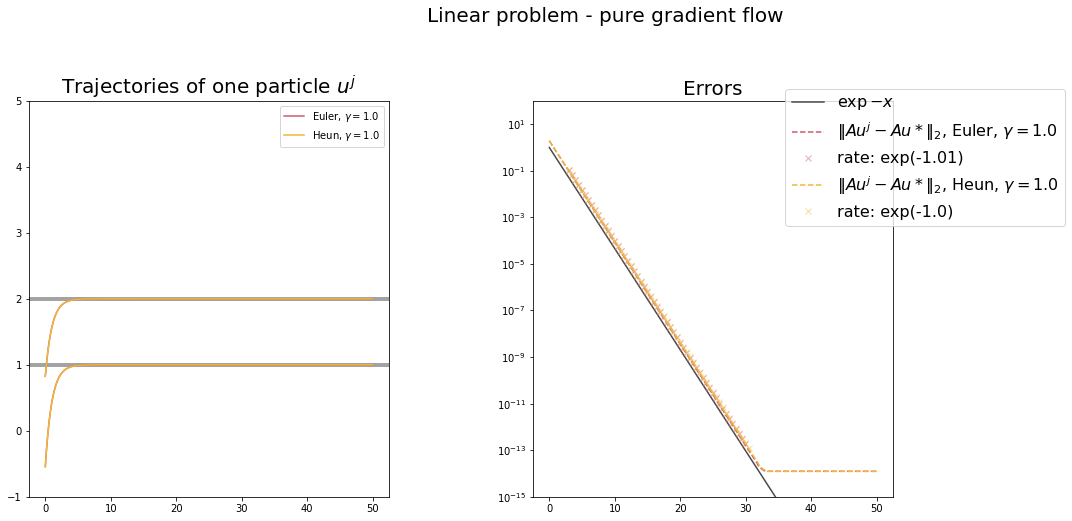

In [312]:
# Set parameters
T=50
h=.01
J=5
N=int(T/h)
n=2
m=2
gamma=1.

#set parameters in a variable
pars = [h,J,N,n,m,gamma,u_star]

## Run similations with set parameters 
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,euler_step,force_eki,pars)
ax,fig=set_plot_semilog(t_vec, "Linear problem - pure gradient flow",u_star)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler, $\gamma=$"+str(gamma),2,A_operator)

gamma=1.
pars = [h,J,N,n,m,gamma,u_star]
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,heun_step,force_eki,pars)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun, $\gamma=$"+str(gamma),3,A_operator)


# fig.savefig("res_linear_overdamped.pdf",format="pdf")


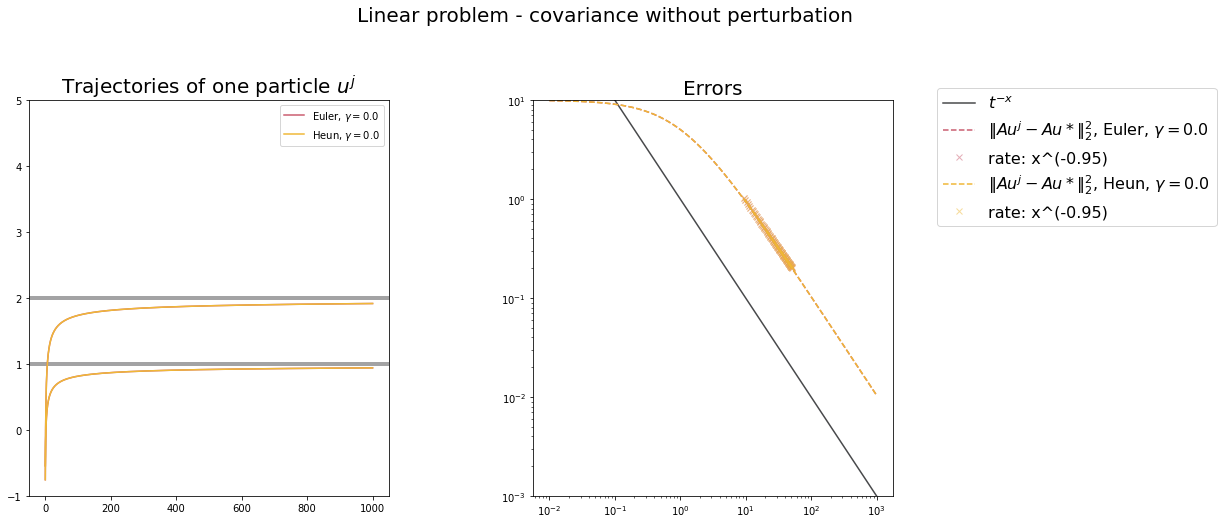

In [307]:
# Set parameters
T=1000
h=.01
J=3
N=int(T/h)
n=2
m=2
gamma=0.

#set parameters in a variable
pars = [h,J,N,n,m,gamma,u_star]

## Run similations with set parameters 
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,euler_step,force_eki,pars)
ax,fig=set_plot_loglog(t_vec, "Linear problem - covariance without perturbation",u_star)
plot_res_loglog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler, $\gamma=$"+str(gamma),2,A_operator)

pars = [h,J,N,n,m,gamma,u_star]
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,heun_step,force_eki,pars)
plot_res_loglog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun, $\gamma=$"+str(gamma),3,A_operator,[0.2,10**0],[10**(-3),10])



### Non linear operator

In [ ]:

## Use non-linear operator 
def A_u_nonlin(q):
    Au=4*q**(3)+q**2
    return Au
A_operator = A_u_nonlin
y=A_operator(u_star)

# Generate obs
print("y")
y=A_operator(u_star)
print(y)

y
[ 5. 36.]


<ipython-input-8-b336b8d766c3>:3: RuntimeWarning: overflow encountered in power
  Au=4*q**(3)+q**2
<ipython-input-8-b336b8d766c3>:3: RuntimeWarning: overflow encountered in square
  Au=4*q**(3)+q**2
/home/s2133976/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py:2556: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
<ipython-input-4-a654c0a035d7>:6: RuntimeWarning: invalid value encountered in subtract
  Cup=(u_k-u_k_mean)@(A_u(u_k)-A_u(u_k_mean)).T/(J)


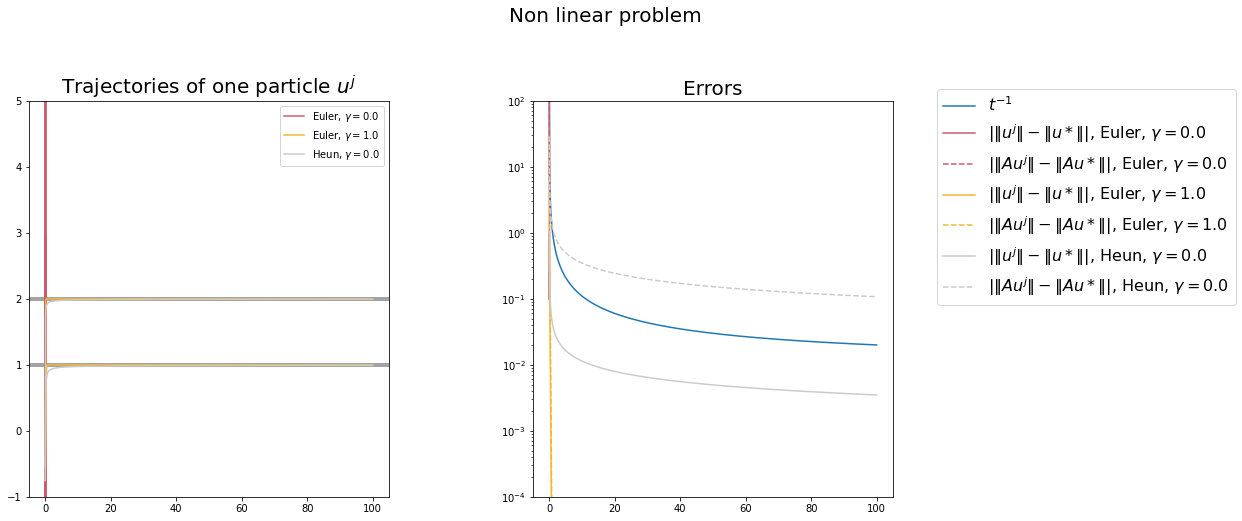

In [ ]:
# Set parameters
T=100
h=.01
J=3
N=int(T/h)
n=2
m=2
gamma=.00

#set parameters in a variable
pars = [h,J,N,n,m,gamma]

## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,euler_step,force_eki,pars)
ax,fig=set_plot(t_vec,"Non linear problem",u_star)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler, $\gamma=$"+str(gamma),2,A_operator)

gamma=1.
pars = [h,J,N,n,m,gamma]
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,euler_step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler, $\gamma=$"+str(gamma),3,A_operator)

gamma=.00
pars = [h,J,N,n,m,gamma]
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,heun_step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun, $\gamma=$"+str(gamma),4,A_operator)

fig.savefig("res_nonlinear_overdamped.pdf",format="pdf")


## Underdamped EKI

\begin{align}
    &\frac{du^{(j)}}{dt} = v^{(j)}\\
    &\frac{dv^{(j)}}{dt}=- (C(u)+ \eta(u^j - \bar{u}) )\nabla \Phi(u^{j}) - \alpha v^{(j)}
\end{align}

### Momentum 
- Euler (it is not the best)
\begin{align}
p_{n+1} & = p_n(1-\alpha) + hf(q_n)\\
q_{n+1} & = q_n + hp_{n+1}
\end{align}

- Symplectic Euler (it's better)
\begin{align}
p_{n+1} & = p_n - hU'(q_n)\\
q_{n+1} & = q_n + hp_{n+1}
\end{align}

-<span style="color:blue"> Momentum (as seen by optimisers) 
When I look at optimiser methods, like momentum SGD, I get this update (the difference is essentially in the step size in front of $p$:
SGD Momentum:
\begin{align}
p_{n+1} & = \gamma p_n + h U'(q_n)\\
q_{n+1} & = q_n -p_{n+1}
\end{align}
</span>

using: \[1]: https://www.ruder.io/optimizing-gradient-descent/

- Heun's method for $y' = f(y)$
\begin{align}
&\hat{u}_{n+1} = u_n + h p\\
&\hat{p}_{n+1} = p_n(1-\alpha) + h f(u_n)\\
&u_{n+1} = u_n + 0.5 h (p_{n+1} + \hat{p}_{n+1} )\\
&p_{n+1} = p_n(1-\alpha) + \frac{h}{2} (f(q_n) + f(\hat{q}_{n+1}))
\end{align}

- Actually solve one of the equation (we derive these equations by first solving the Hamiltonian part with a symplectic Euler discretisation then solving the equation for just the damping which introduces the exponential factor).
$$
\begin{align}
\dot{x}  =  p\\
\dot{p}  =  -\nabla f(x) - \gamma p
\end{align}
$$

$$
\begin{align}
x_{n+1}   = x_n + h p_n\\
p_{n+1}   =  \exp(-\gamma h) [p_n -h\nabla f(x_{n+1})]
\end{align}
$$

- Numerical methods with projection 
we could also try numerical methods with 
$$
H(\hat{q}_{n+1}, \alpha \hat{p}_{n+1}) = \alpha^2 \|\hat{p}_{n+1}\|^2/2 + U(\hat{q}_{n+1}) = E
$$
Finally solve for $\alpha$:
$$
\alpha = + \frac
{
\sqrt{
2(E - U(\hat{q}_{n+1}))
}
}
{\|\hat{p}_{n+1}\|}
$$


### Nesterov accelerated momentum
<span style="color:blue">In *Nesterov Accelerated Gradient*, the update rule is slightly modified to "peek" into the future:</span>

$$p_{t+1} = \gamma p_{t} - \eta f(q_{t} - \gamma p_{t})$$
$$q_{t+1} = q_{t} - p_{t+1}$$




In [345]:
def force_eki(u_k,y_obs,A_u,cup,pars):
    n=pars[3]
    gamma=pars[5]
    I2=np.identity(n)
    f=- ((1-gamma)*cup+gamma*I2)@(A_u(u_k)-y_obs)
    return f

def Nesterov(u,p,A_u,cup,y_obs,force,pars):
    h=pars[0]
    alpha=pars[6]
    f=force(u-p*(1-alpha),y_obs,A_u,cup,pars)
    P = p*(1-alpha) -h*f
    U = u -P
    return U,P

def euler_halfexact(u,p,A_u,cup,y_obs,force,pars):
    h=pars[0]
    alpha=pars[6]
    f=force(u,y_obs,A_u,cup,pars)
    U=u+h*p
    P=np.exp(-alpha*h)*(p+h*f)
    return U,P

def euler_step_under(u,p,A_u,cup,y_obs,force,pars):
    h=pars[0]
    alpha=pars[6]
    f=force(u,y_obs,A_u,cup,pars)
    U=u+h*p
    P=p*(1-alpha)+h*f
    return U,P

    
def SE_Step(u,p,A_u,cup,y_obs,force,pars):
    h=pars[0]
    alpha=pars[6]
    f=force(u,y_obs,A_u,cup,pars)
    P = p*(1-alpha) + h*f
    U = u + h*P
    return U,P

def SE_Step_momentum(u,p,A_u,cup,y_obs,force,pars):
    h=pars[0]
    alpha=pars[6]
    f=force(u,y_obs,A_u,cup,pars)
    P = p*(1-alpha) + h*f
    U = u+P
    return U,P


def heun_step_under(u,p,A_u,cup,y_obs,force,pars):
    h=pars[0]
    alpha=pars[6]
    F1 = force(u,y_obs,A_u,cup,pars)
    Uhat = u + h*p
    Phat = p*(1-alpha) + h*F1

    U = u + h/2.*(p + Phat)

    F2 = force(Uhat,y_obs,A_u,cup,pars)

    P = p*(1-alpha) + 0.5*h*(F1 + F2)
    return U,P
    

    
def eki_underdamped(A_u,y,step,force,pars):
    """
    Input
    ----- 
        A: matrix or function
        operator

        h: float
        stepsize

        J: int
        number of particles

        N: int
        number of steps forward, h is defined as T/N

        y: array nx1
        observations 

        n: int
        number of observations 

        m: int
        A is of size mxn

        gamma: float between 0 and 1
        parameter to weight the covariance matrix with the extra inflation

        euler: function
        function that compute the step forward

        force: 
        function which computes the force


    Output
    ------
        error: float

        return the relative error as defined by:$ \| 1/J \Sum_{j=1}^{J} (u^j_N) - u^*\| / \|1/J \Sum_{j=1}^{J} (u^j_0)  - u^* \|$
    """

    np.random.seed(123)

    # set parameters 
    h=pars[0]
    J=pars[1]
    N=pars[2]
    n=pars[3]
    m=pars[4]

    ustar=pars[7]
    Aus = A_u(ustar)
    ustar_tile = np.tile(ustar.reshape(m,1),J)
    Aus_tile = np.tile(Aus.reshape(m,1),J)

    # set initial conditions 
    u_k=np.random.normal(0,0.5,(n,J))
    p_k=np.random.normal(0,0.5,(n,J))
    y_obs=np.tile(y.reshape(m,1),J)

    # set empty vectors to save norm values of each u^{(j)}
    u_norm_saved=np.zeros((J,N))
    Au_norm_saved=np.zeros((J,N))

    # set empty vectors to save values of each dimensions of u^{(j)}
    ux_saved=np.zeros((J,N))
    uy_saved=np.zeros((J,N))

    # set empty vectors to save values of each dimensions of u^{(j)}
    px_saved=np.zeros((J,N))
    py_saved=np.zeros((J,N))

    # set time to save after
    t=0
    t_vec=np.zeros(N)

    for i in range(N):
        # compute the time
        t+=h
        t_vec[i]=t

        # compute the covariance matrix
        cup=mat_cup(u_k,A_u,pars)
        u_k,p_k=step(u_k,p_k,A_u,cup,y_obs,force,pars)

        # map forward operator
        Au=A_u(u_k)
        
        #save the norm
        u_norm_saved[:,i]=np.linalg.norm(u_k-ustar_tile,axis=0)**2
        # save the norm
        Au_norm_saved[:,i]=np.linalg.norm(Au-Aus_tile,axis=0)

        # save the value of ux and uy 
        ux_saved[:,i]=u_k[0,:]
        uy_saved[:,i]=u_k[1,:]

        #save the values of px and py
        px_saved[:,i]=p_k[0,:]
        py_saved[:,i]=p_k[1,:]

    return u_norm_saved,Au_norm_saved,ux_saved,uy_saved,t_vec,px_saved,py_saved


### Linear problem


In [388]:
print("Solution is $u^*$")
u_star =np.array([1.,2.])
print(u_star)

# ## Use linear operator
A = np.array([[100., 0.0],[0.,0.001]]) #,[1., 0.5]])
print("Determinant of A")
print(np.linalg.det(A))
 
def A_u(q):
    Au=A@q
    return Au
A_operator = A_u # or A_u_nonlin

# Generate obs
print("y")
y=A_operator(u_star)
print(y)

Solution is $u^*$
[1. 2.]
Determinant of A
0.10000000000000006
y
[1.e+02 2.e-03]


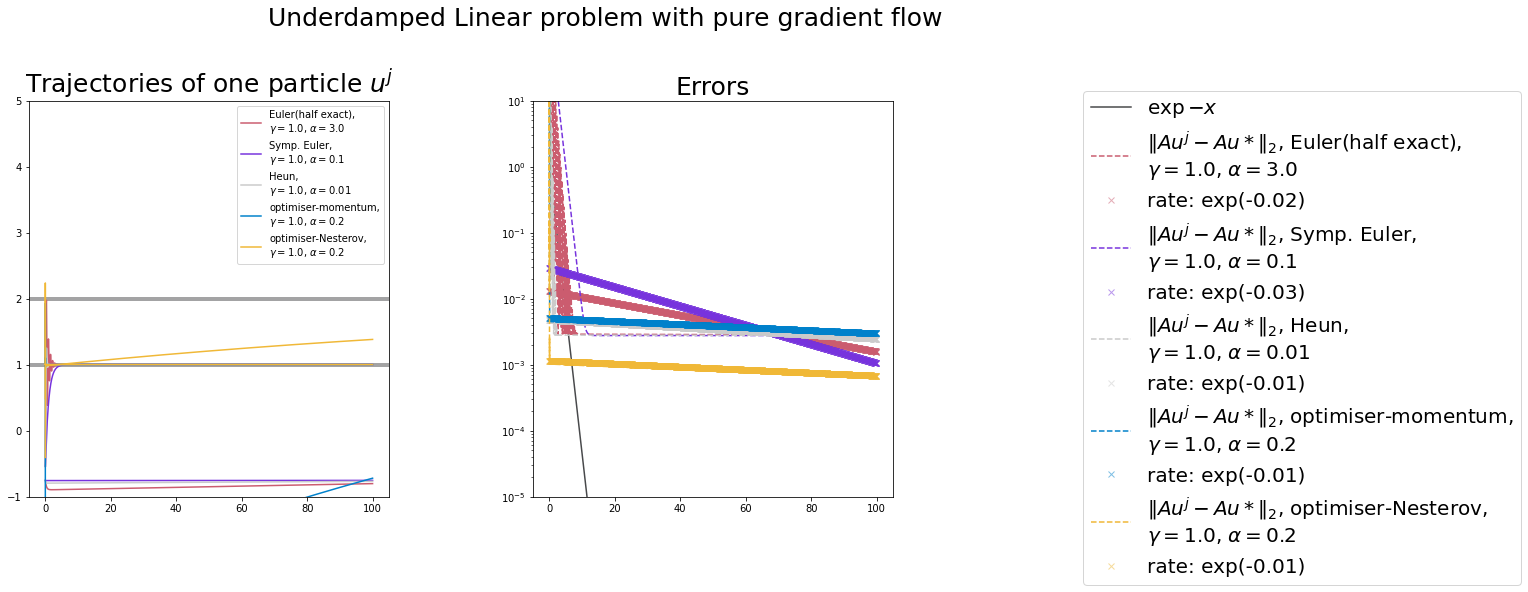

In [390]:
# Set parameters
T=100
h=0.001
J=3
N=int(T/h)
n=2
m=2
gamma=1. #covariance inflation parameter

alpha=3. #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,euler_halfexact,force_eki,pars)
ax,fig=set_plot_semilog(t_vec,"Underdamped Linear problem with pure gradient flow",u_star)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler(half exact),\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Symp. Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),6,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=0.01 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,heun_step_under,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),4,A_operator,lim_m=False,ylim=[10**(-5),10**1])


alpha=0.2 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),1,A_operator,False,[10**(-5),10**1])

alpha=0.2 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,Nesterov,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-Nesterov,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),3,A_operator,False,[10**(-5),10**1])

fig.savefig("res_linear_underdamped_gamma1.pdf",format="pdf")

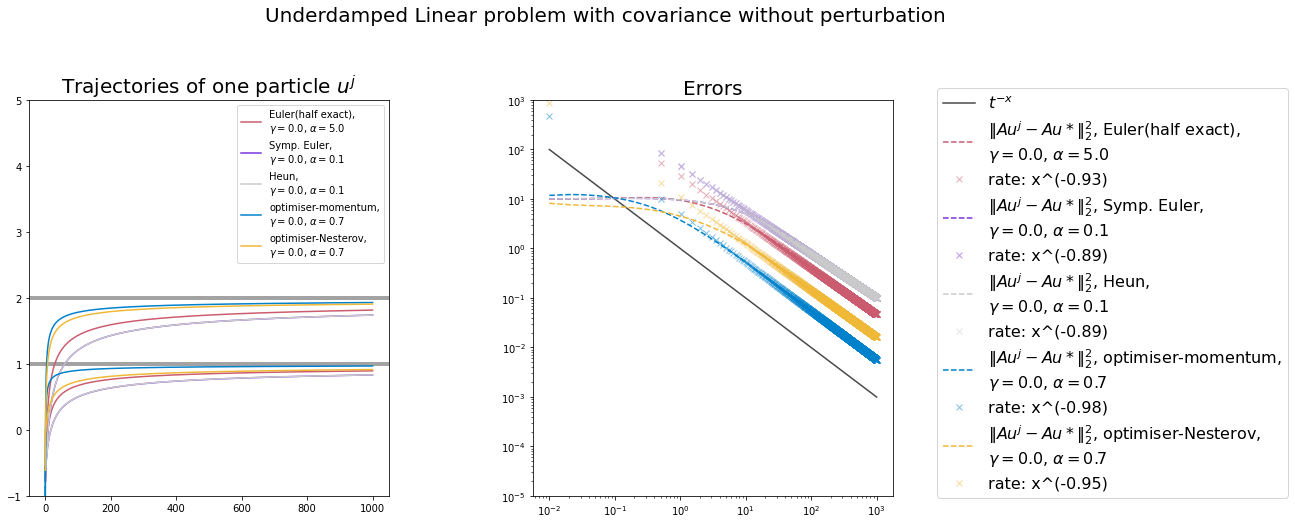

In [369]:
# Set parameters
T=1000
h=0.01
J=3
N=int(T/h)
n=2
m=2
gamma=0. #covariance inflation parameter

alpha=5. #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,euler_halfexact,force_eki,pars)
ax,fig=set_plot_loglog(t_vec,"Underdamped Linear problem with covariance without perturbation",u_star)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler(half exact),\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Symp. Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),6,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=0.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,heun_step_under,force_eki,pars)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),4,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=0.7 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),1,A_operator,False,[10**(-5),10**1])

alpha=0.7 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,Nesterov,force_eki,pars)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-Nesterov,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),3,A_operator,False,[10**(-5),10**3])

fig.savefig("res_linear_underdamped_gamma0.pdf",format="pdf")

### Look at optimiser with different friction parameters - focus on optimiser momentum


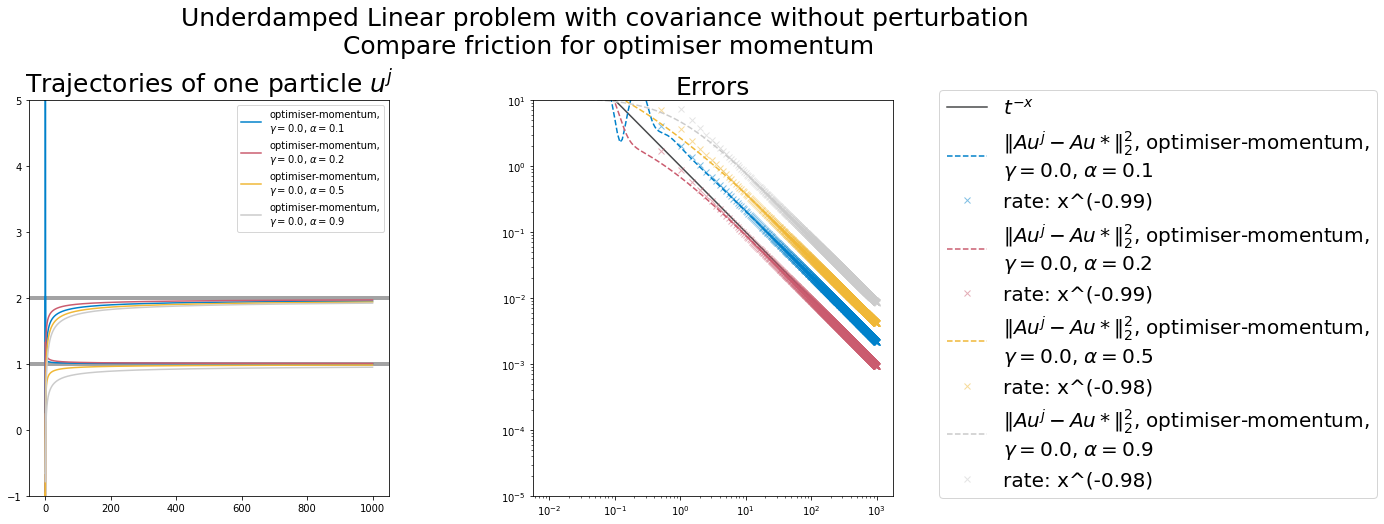

In [387]:
# Set parameters
T=1000
h=0.01
J=3
N=int(T/h)
n=2
m=2
gamma=0. #covariance inflation parameter

alpha=.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
ax,fig=set_plot_loglog(t_vec,"Underdamped Linear problem with covariance without perturbation\n Compare friction for optimiser momentum",u_star)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),1,A_operator,False,[10**(-5),10**1])

alpha=0.2 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator,False,[10**(-5),10**1])


alpha=0.5 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),3,A_operator,False,[10**(-5),10**1])

alpha=0.9 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_loglog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),4,A_operator,False,[10**(-5),10**1])

fig.savefig("opti_momentum_underdamped_gamma0.pdf",format="pdf")

### Non linear problem

y
[ 5. 36.]


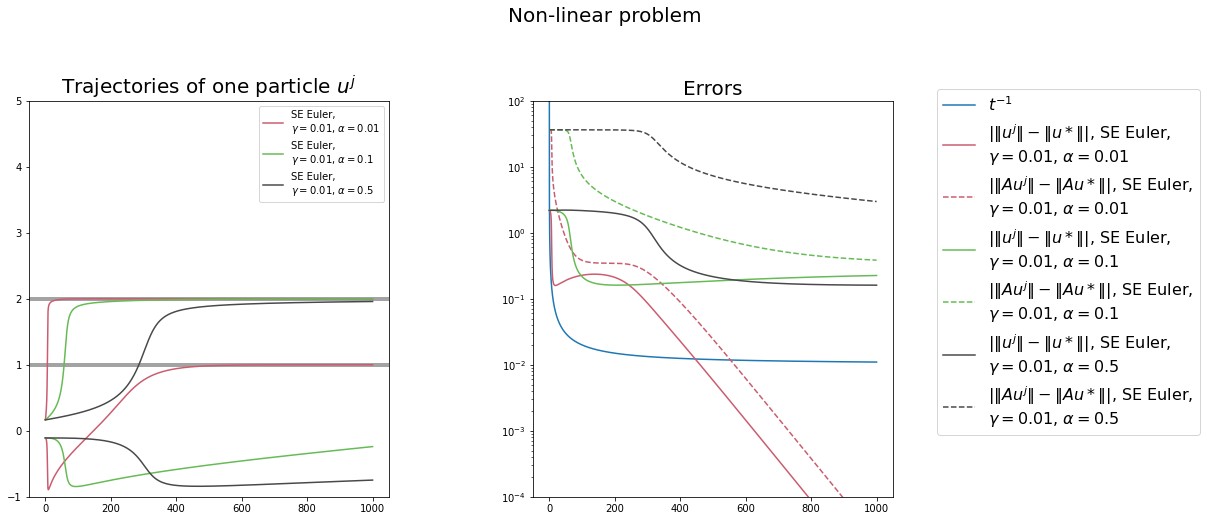

In [ ]:
## Use non-linear operator 
def A_u_nonlin(q):
    Au=4*q**(3)+q**2
    return Au
A_operator = A_u_nonlin
y=A_operator(u_star)

# Generate obs
print("y")
y=A_operator(u_star)
print(y)

# Set parameters
T=1000
h=0.001
J=5
N=int(T/h)
n=2
m=2
gamma=.01 #covariance inflation parameter
alpha=0.01 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]

## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
ax,fig=set_plot(t_vec,"Non-linear problem",u_star)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator)


gamma=.01 #covariance inflation parameter
alpha=0.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),5,A_operator)


gamma=.01 #covariance inflation parameter
alpha=0.5 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),0,A_operator)
fig.savefig("res_nonlinear_underdamped_gamma001.pdf",format="pdf")

In [ ]:
## Use non-linear operator 
def A_u_nonlin(q):
    Au=4*q**(3)+q**2
    return Au
A_operator = A_u_nonlin
y=A_operator(u_star)

# Generate obs
print("y")
y=A_operator(u_star)
print(y)

# Set parameters
T=1000
h=0.001
J=5
N=int(T/h)
n=2
m=2
gamma=.0 #covariance inflation parameter
alpha=0.01 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]

## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
ax,fig=set_plot(t_vec,"Non-linear problem",u_star)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator)


gamma=.01 #covariance inflation parameter
alpha=0.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),5,A_operator)


gamma=.01 #covariance inflation parameter
alpha=0.5 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),0,A_operator)
fig.savefig("res_nonlinear_underdamped_gamma001.pdf",format="pdf")

## Compare EKI overdamped and underdamped 
### Linear problem with gamma=0

In [ ]:
print("Solution is $u^*$")
u_star =np.array([1.,2.])
print(u_star)

# ## Use linear operator
A = np.array([[1., 0.0],[0.,1.]]) #,[1., 0.5]])
print("Determinant of A")
print(np.linalg.det(A))
 
def A_u(q):
    Au=A@q
    return Au
A_operator = A_u # or A_u_nonlin

# Generate obs
print("y")
y=A_operator(u_star)
print(y)

Solution is $u^*$
[1. 2.]
Determinant of A
1.0
y
[1. 2.]


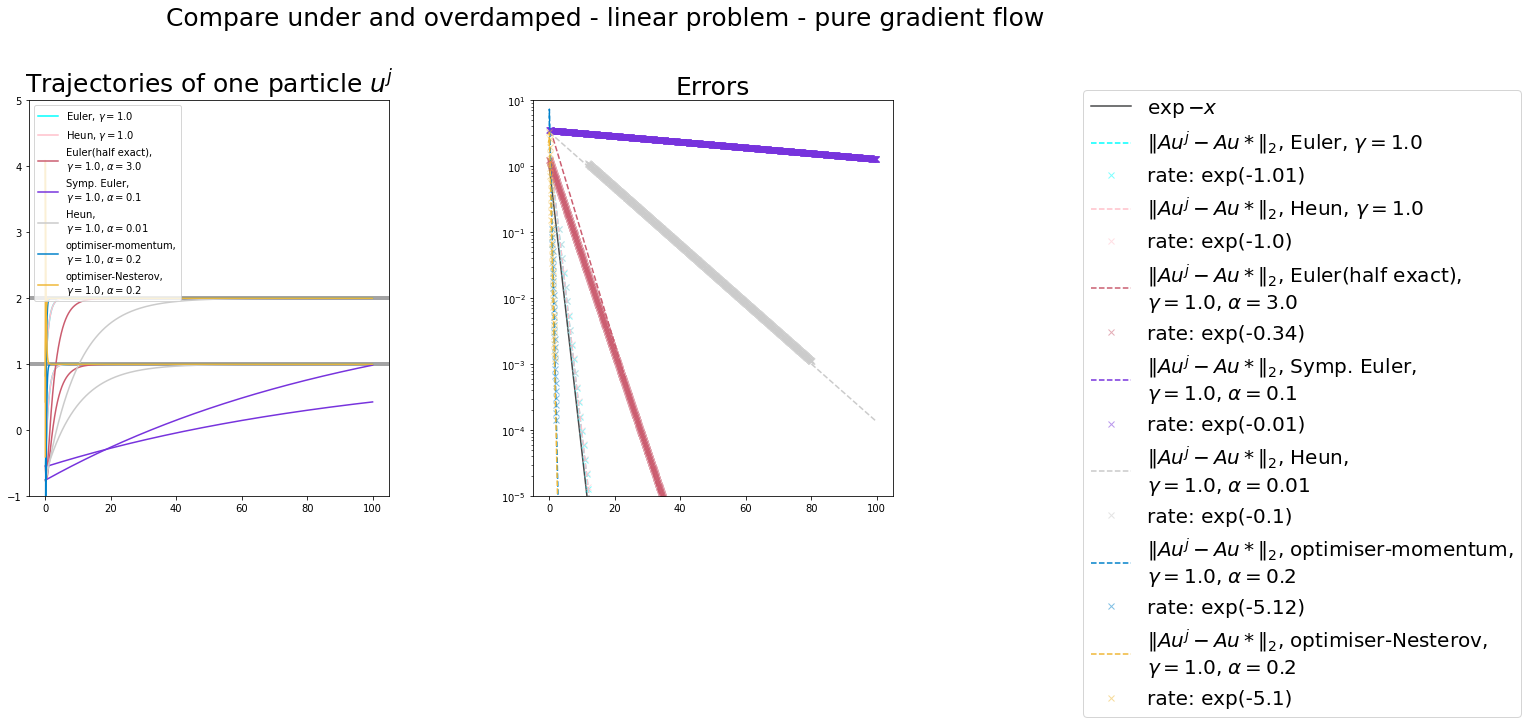

In [381]:

# Set parameters
T=100
h=.01
J=5
N=int(T/h)
n=2
m=2
gamma=1.

#set parameters in a variable
pars = [h,J,N,n,m,gamma,u_star]

## Run similations with set parameters 
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,euler_step,force_eki,pars)
ax,fig=set_plot_semilog(t_vec, "Compare under and overdamped - linear problem - pure gradient flow",u_star)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler, $\gamma=$"+str(gamma),7,A_operator)

gamma=1.
pars = [h,J,N,n,m,gamma,u_star]
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,heun_step,force_eki,pars)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun, $\gamma=$"+str(gamma),8,A_operator)


# Set parameters
T=100
h=0.001
J=3
N=int(T/h)
n=2
m=2
gamma=1. #covariance inflation parameter

alpha=3. #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,euler_halfexact,force_eki,pars)
# ax,fig=set_plot_semilog(t_vec,"Underdamped Linear problem with pure gradient flow",u_star)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler(half exact),\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Symp. Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),6,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=0.01 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,heun_step_under,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),4,A_operator,lim_m=[10**(-3),10**0],ylim=[10**(-5),10**1])


alpha=0.2 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),1,A_operator,[10**(-4),10**(-1)],[10**(-5),10**1])

alpha=0.2 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,Nesterov,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-Nesterov,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),3,A_operator,[0.001,3],[10**(-5),10**1])

fig.savefig("comp_under_over_linear_underdamped_gamma1.pdf",format="pdf")

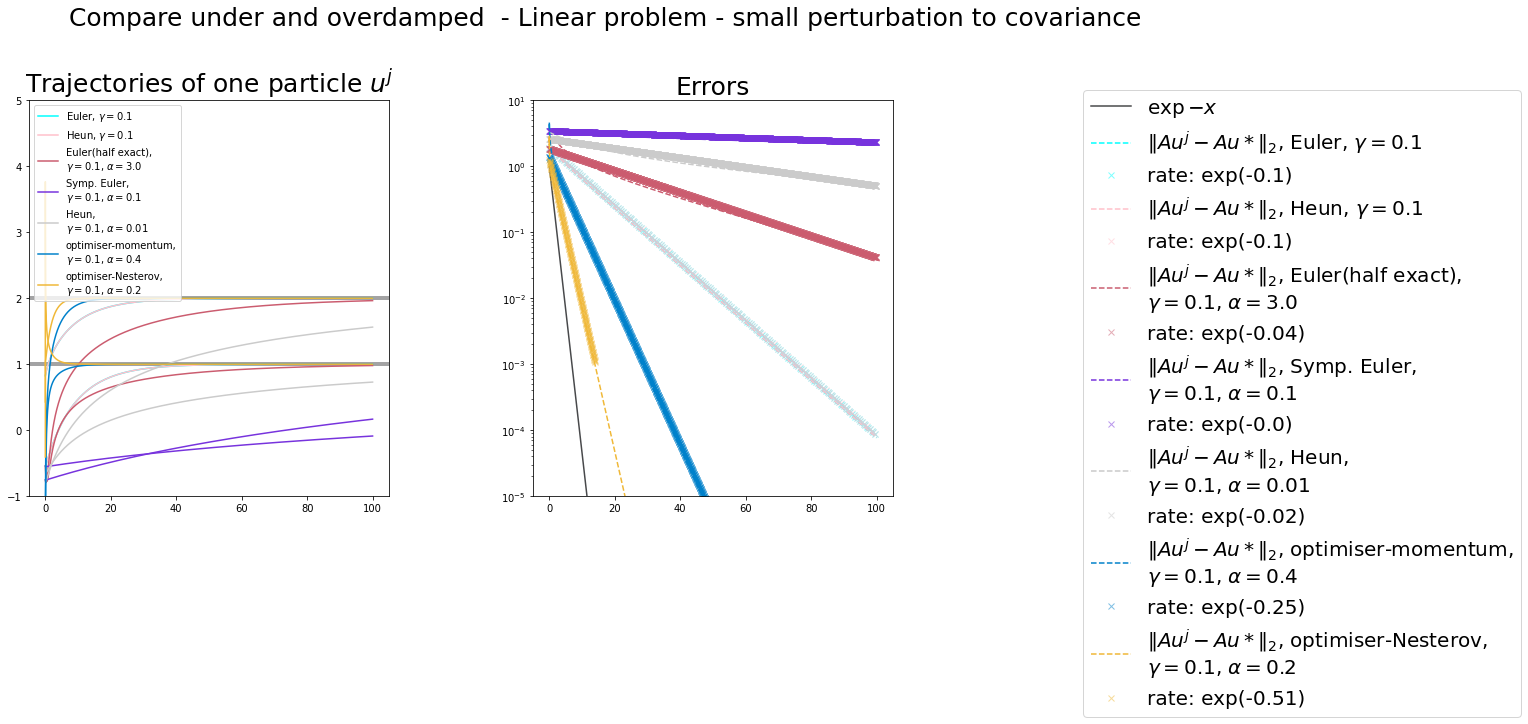

In [383]:

# Set parameters
T=100
h=.01
J=5
N=int(T/h)
n=2
m=2
gamma=0.1

#set parameters in a variable
pars = [h,J,N,n,m,gamma,u_star]

## Run similations with set parameters 
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,euler_step,force_eki,pars)
ax,fig=set_plot_semilog(t_vec, "Compare under and overdamped  - Linear problem - small perturbation to covariance",u_star)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler, $\gamma=$"+str(gamma),7,A_operator,False)

pars = [h,J,N,n,m,gamma,u_star]
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,heun_step,force_eki,pars)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun, $\gamma=$"+str(gamma),8,A_operator,False)


# Set parameters
T=100
h=0.001
J=3
N=int(T/h)
n=2
m=2

alpha=3. #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,euler_halfexact,force_eki,pars)
# ax,fig=set_plot_semilog(t_vec,"Underdamped Linear problem with pure gradient flow",u_star)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler(half exact),\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Symp. Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),6,A_operator,lim_m=False,ylim=[10**(-5),10**1])

alpha=0.01 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
# Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,heun_step_under,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),4,A_operator,lim_m=False,ylim=[10**(-5),10**1])


alpha=0.4 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),1,A_operator,False,[10**(-5),10**1])

alpha=0.2 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,Nesterov,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-Nesterov,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),3,A_operator,[0.001,3],[10**(-5),10**1])

fig.savefig("comp_under_over_linear_underdamped_gamma1.pdf",format="pdf")

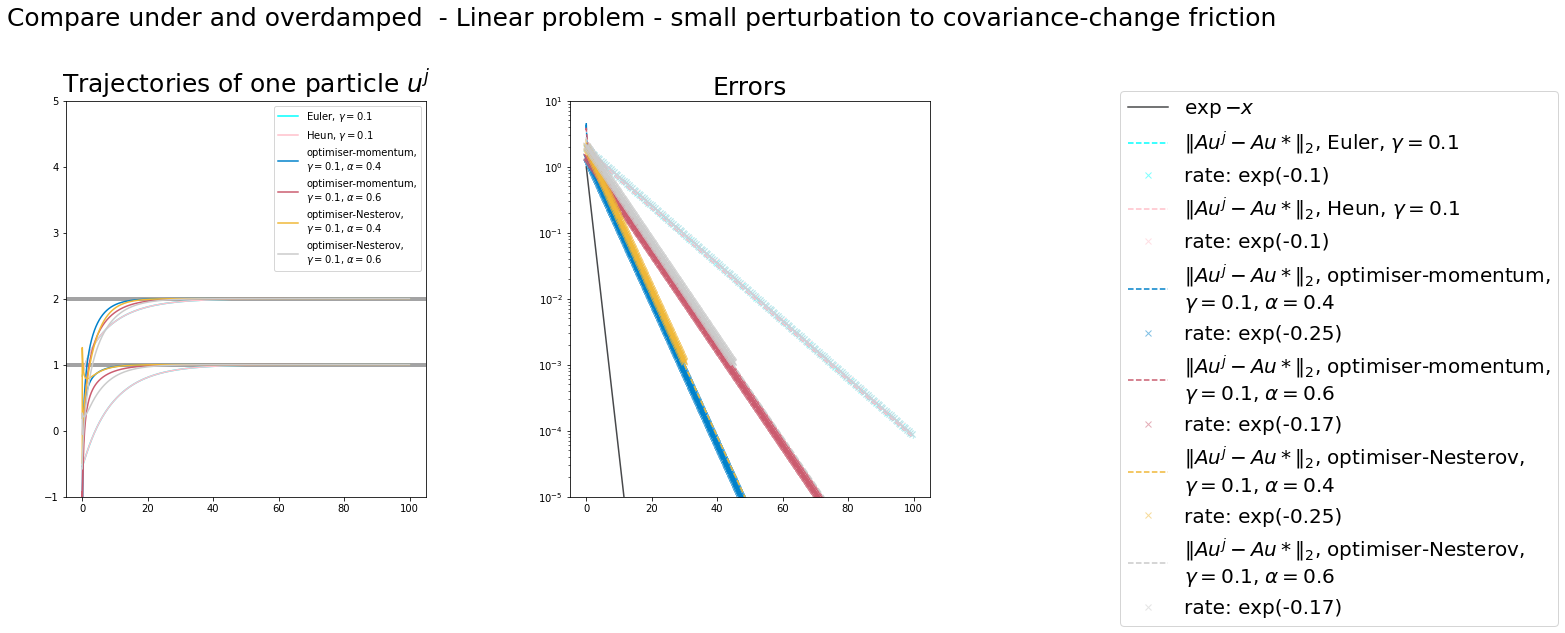

In [386]:

# Set parameters
T=100
h=.01
J=5
N=int(T/h)
n=2
m=2
gamma=0.1

#set parameters in a variable
pars = [h,J,N,n,m,gamma,u_star]

## Run similations with set parameters 
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,euler_step,force_eki,pars)
ax,fig=set_plot_semilog(t_vec, "Compare under and overdamped  - Linear problem - small perturbation to covariance-change friction",u_star)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Euler, $\gamma=$"+str(gamma),7,A_operator,False)

pars = [h,J,N,n,m,gamma,u_star]
u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec = eki_overdamped(A_operator,y,heun_step,force_eki,pars)
plot_res_semilog(u_norm,Au_norm,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"Heun, $\gamma=$"+str(gamma),8,A_operator,False)


# Set parameters
T=100
h=0.001
J=3
N=int(T/h)
n=2
m=2



alpha=0.4 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),1,A_operator,False,[10**(-5),10**1])


alpha=0.6 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step_momentum,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-momentum,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator,False,[10**(-5),10**1])


alpha=0.4 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,Nesterov,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-Nesterov,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),3,A_operator,[0.001,3],[10**(-5),10**1])

alpha=0.6 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha,u_star]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,Nesterov,force_eki,pars)
plot_res_semilog(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"optimiser-Nesterov,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),4,A_operator,[0.001,3],[10**(-5),10**1])


fig.savefig("comp_under_over_linear_underdamped_gamma1.pdf",format="pdf")

### Non Linear problem

In [ ]:
## Use non-linear operator 
def A_u_nonlin(q):
    Au=4*q**(3)+q**2
    return Au
A_operator = A_u_nonlin
y=A_operator(u_star)

# Generate obs
print("y")
y=A_operator(u_star)
print(y)

y
[ 5. 36.]


## Try a harder non linear problem (to do)

In [ ]:
pars = [0.1,0.1,-0.1, -10]
from scipy.special import logit, expit

def f(x,y,pars):
    return -logit(pars[0]*expit(pars[2]*((x-2)**4+y**4)) + pars[1]*expit(pars[3]*((x+1)**2+y**2)))

def fx(x,y,pars,eps):
    return (f(x+eps,y,pars)-f(x-eps,y,pars))/(2*eps)

def fy(x,y,pars,eps):
    return (f(x, y+eps,pars)-f(x,y-eps,pars))/(2*eps)

def U_Trap(x,pars):
    return f(x[0],x[1],pars)
    
def VF_Trap(x,pars):
    #print(gx(x[0],x[1], pars),g(x[0],x[1],pars))
    return -np.array([fx(x[0],x[1],pars,1e-6), fy(x[0],x[1],pars,1e-6)])

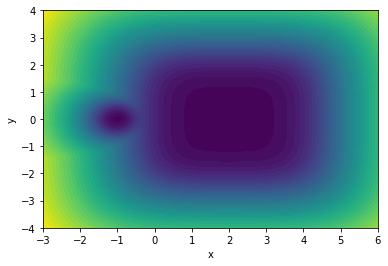

In [ ]:
# x_t = ODE_integrate(np.array([-2,2]), 0.01, 1000, VF_Trap, pars, Euler_Step)
xx = np.linspace(-3, 6, 101)
yy = np.linspace(-4, 4, 101)
xv, yv = np.meshgrid(xx, yy)
zv = U_Trap([xv,yv],pars)
plt.contourf(xv,yv,np.log(zv),50)
plt.xlabel('x')
plt.ylabel('y')
# plt.plot(x_t[:,0], x_t[:,1],'w.')
plt.show()

y
[ 5. 36.]


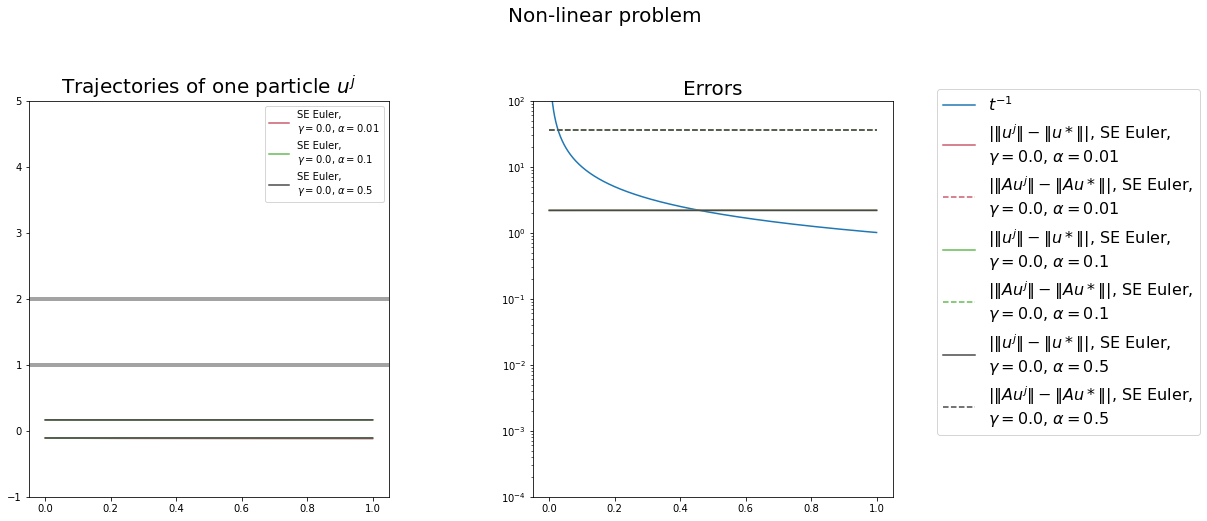

In [ ]:

## Use non-linear operator 
def A_u_nonlin(q):
    Au=4*q**(3)+q**2
    return Au
A_operator = A_u_nonlin
y=A_operator(u_star)

# Generate obs
print("y")
y=A_operator(u_star)
print(y)

# Set parameters
T=1
h=0.001
J=5
N=int(T/h)
n=2
m=2
gamma=.0 #covariance inflation parameter
alpha=0.01 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]

## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
ax,fig=set_plot(t_vec,"Non-linear problem",u_star)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),2,A_operator)


alpha=0.1 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),5,A_operator)


alpha=0.5 #friction parameters in underdamped model
#set parameters in a variable
pars = [h,J,N,n,m,gamma,alpha]
## Run similations with set parameters 
u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,px,py = eki_underdamped(A_operator,y,SE_Step,force_eki,pars)
plot_res(u_norm_saved,Au_norm_saved_over,ux_saved_over,uy_saved_over,t_vec,u_star,ax,"SE Euler,\n$\gamma=$"+str(gamma)+", $\\alpha=$"+str(alpha),0,A_operator)
fig.savefig("res_nonlinear_underdamped_gamma0.pdf",format="pdf")

In [ ]:
n=1
q_traj = ux_saved[n,:]
p_traj = uy_saved[n,:]
plt.plot(q_traj,p_traj,"-") #'b.')
plt.xlabel('q');
plt.ylabel('p');
plt.title('Euler method solution of linear system')
plt.show()

NameError: name 'ux_saved' is not defined

## Compare EKI overdamped and underdamped 